## Определение перспективного тарифа для телеком компании «Мегалайн»

Необходимо определить какой тариф приносит бОльшую выручку компании: тариф "Смарт" или тариф "Ультра".

В распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

### Информация о входных данных
__Таблица users (информация о пользователях):__
- *user_id* — уникальный идентификатор пользователя
- *first_name* — имя пользователя
- *last_name* — фамилия пользователя
- *age* — возраст пользователя (годы)
- *reg_date* — дата подключения тарифа (день, месяц, год)
- *churn_date* — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- *city* — город проживания пользователя
- *tariff* — название тарифного плана

__Таблица calls (информация о звонках):__
- *id* — уникальный номер звонка
- *call_date* — дата звонка
- *duration* — длительность звонка в минутах
- *user_id* — идентификатор пользователя, сделавшего звонок

__Таблица messages (информация о сообщениях):__
- *id* — уникальный номер сообщения
- *message_date* — дата сообщения
- *user_id* — идентификатор пользователя, отправившего сообщение

__Таблица internet (информация об интернет-сессиях):__
- *id* — уникальный номер сессии
- *mb_used* — объём потраченного за сессию интернет-трафика (в мегабайтах)
- *session_date* — дата интернет-сессии
- *user_id* — идентификатор пользователя

__Таблица tariffs (информация о тарифах):__
- *tariff_name* — название тарифа
- *rub_monthly_fee* — ежемесячная абонентская плата в рублях
- *minutes_included* — количество минут разговора в месяц, включённых в абонентскую плату
- *messages_included* — количество сообщений в месяц, включённых в абонентскую плату
- *mb_per_month_included* — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- *rub_per_minute* — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- *rub_per_message* — стоимость отправки сообщения сверх тарифного пакета
- *rub_per_gb* — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

__NOTE__
Обратите внимание: «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.

### План исследования:
- провести предобработку данных (найти и по-возможности заполнить пропуски, найти и удалить дубликаты, привести данные к соответствующим типам данных);
- посчитать помесячную выручку для каждого пользователя (выручка от абонентской платы + выручка от услуг сверх тарифного пакета);
-  описать две выборки: группа "Смарт" и группа "Ультра" (среднее, дисперсию и стандартное отклонение для количества минут, количества сообщений, объема трафика)
- проверить три гипотезы: 
> 1.   средние ежемесячные выручки пользователей тарифов ULTRA и SMART различаются;
> 2.   средняя ежемесячная выручка пользователей ULTRA превышает среднюю ежемесячную выручку пользователей SMART;
> 3. средняя ежемесячная выручка пользователей из Москвы отличается от аналогичной выручки пользователей из других регионов.
- сделать выводы.



In [1]:
%pylab inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as st

pd.options.display.max_columns = 9999 # чтобы скролить таблицу по горизонтали

Populating the interactive namespace from numpy and matplotlib


In [3]:
path = ''
users = pd.read_csv(path + 'users.csv')
calls = pd.read_csv(path + 'calls.csv')
messages = pd.read_csv(path + 'messages.csv')
internet = pd.read_csv(path + 'internet.csv')
tariffs = pd.read_csv(path + 'tariffs.csv')
df_list = [users, calls, messages, internet, tariffs]

In [4]:
for df in df_list:
    print(df.shape[0], df.isna().mean())
    print('Количество дубликатов: ', df.duplicated().sum())
# пропусков много в churn_date в пользователях, для них тариф еще действует, в остальном норм

500 user_id       0.000
age           0.000
churn_date    0.924
city          0.000
first_name    0.000
last_name     0.000
reg_date      0.000
tariff        0.000
dtype: float64
Количество дубликатов:  0
202607 id           0.0
call_date    0.0
duration     0.0
user_id      0.0
dtype: float64
Количество дубликатов:  0
123036 id              0.0
message_date    0.0
user_id         0.0
dtype: float64
Количество дубликатов:  0
149396 Unnamed: 0      0.0
id              0.0
mb_used         0.0
session_date    0.0
user_id         0.0
dtype: float64
Количество дубликатов:  0
2 messages_included        0.0
mb_per_month_included    0.0
minutes_included         0.0
rub_monthly_fee          0.0
rub_per_gb               0.0
rub_per_message          0.0
rub_per_minute           0.0
tariff_name              0.0
dtype: float64
Количество дубликатов:  0


### Предобработка данных по пользователям

In [5]:
# т.к. данные за весь 2018 год, то для тех у кого договор еще действует
# заполним пропуски в churn_date на 31 декабря 2018
users['churn_date'] = users['churn_date'].fillna('2018-12-31')

In [6]:
# переведем churn_date и reg_date в формат даты-времени
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

# tariff в единичку и нолик для удобства подсчета: smart -> 0, ultra -> 1
users['tariff'] = users['tariff'].where(users['tariff'] != 'smart', 0)
users['tariff'] = users['tariff'].where(users['tariff'] != 'ultra', 1)
users['tariff'] = users['tariff'].astype('int')


# проверим
users.dtypes

user_id                int64
age                    int64
churn_date    datetime64[ns]
city                  object
first_name            object
last_name             object
reg_date      datetime64[ns]
tariff                 int32
dtype: object

In [7]:
# создадим столбец с привязкой к месяцу, когда клиент начал пользоваться услугами
users['reg_month'] = users['reg_date'].values.astype('datetime64[M]')
# определим кол-во месяцев за которое брать абонентскую плату
users['month_sum'] = users['churn_date'].dt.month - users['reg_date'].dt.month
users.sample(5)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_month,month_sum
313,1313,56,2018-12-31,Ставрополь,Онисим,Суслов,2018-10-24,0,2018-10-01,2
200,1200,36,2018-12-31,Санкт-Петербург,Тамара,Ларионова,2018-04-28,1,2018-04-01,8
245,1245,32,2018-12-31,Москва,Маргарита,Коновалова,2018-09-10,1,2018-09-01,3
96,1096,60,2018-12-31,Брянск,Мариетта,Абашкина,2018-04-01,1,2018-04-01,8
184,1184,21,2018-12-31,Барнаул,Снежана,Тарасова,2018-09-03,0,2018-09-01,3


,index,city
0,Москва,99
1,Санкт-Петербург,39
2,Новосибирск,16
3,Казань,14
4,Омск,14
...,...,...
71,Подольск,1
72,Иваново,1
73,Архангельск,1
74,Химки,1


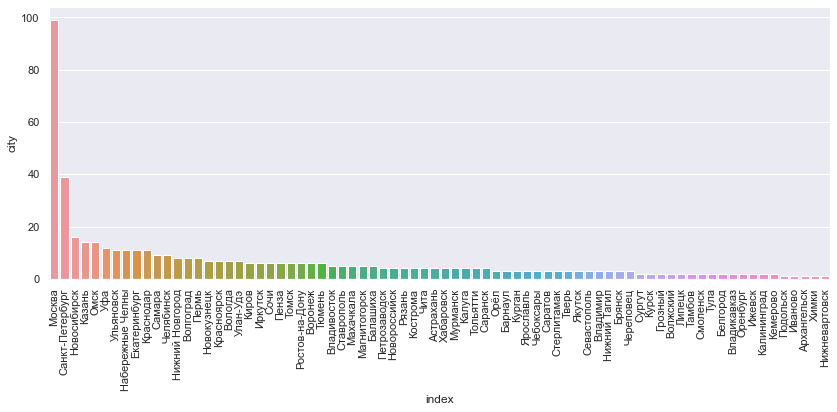

In [8]:
#sns.distplot(users['city'], kde=False, rug=True)
sns.set(style="darkgrid", rc={'figure.figsize':(14,5)})
#sns.set()
city = users['city'].value_counts().reset_index()
ax = sns.barplot(x="index", y="city", data=city)
plt.xticks(rotation=90)
plt.show
city

### Предобработка данных по звонкам

In [9]:
# переименуем стоблец id звонка в call_id, чтобы при объединении таблиц id не перепутались
calls.set_axis(['call_id', 'call_date', 'duration', 'user_id'], axis='columns', inplace=True)
# переведем call_date в формат даты-времени
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
# создадим столбец с разбивкой по месяцам
calls['month'] = calls['call_date'].values.astype('datetime64[M]')
# огруглим длительность звонков вверх как это делает "Мегалайн"
calls['duration_round'] = np.ceil(calls['duration']).astype('int')
calls.head()

,call_id,call_date,duration,user_id,month,duration_round
0,1000_0,2018-07-25,0.00,1000,2018-07-01,0
1,1000_1,2018-08-17,0.00,1000,2018-08-01,0
2,1000_2,2018-06-11,2.85,1000,2018-06-01,3
3,1000_3,2018-09-21,13.80,1000,2018-09-01,14
4,1000_4,2018-12-15,5.18,1000,2018-12-01,6


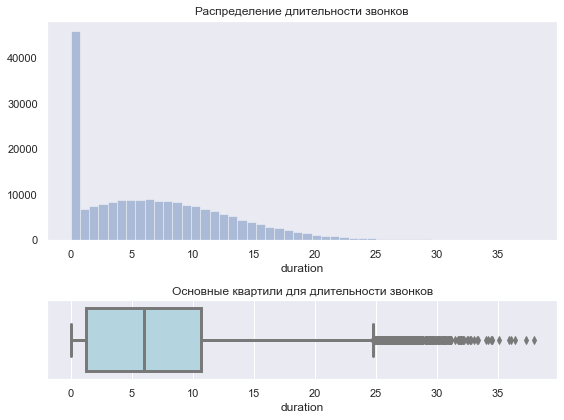

In [10]:
# посмотрим на распределение длительности звонков ВКЛЮЧАЯ звонки нулевой длительности
figsize(8, 6)
ax1 = subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = subplot2grid((3, 1), (2, 0))

sns.distplot(calls.duration, ax=ax1, kde=False)
ax1.set_title("Распределение длительности звонков")
ax1.grid()

sns.boxplot(calls.duration, ax=ax2, linewidth=3, color='lightblue')
ax2.set_title("Основные квартили для длительности звонков")
tight_layout()

In [11]:
# большое количество (20%) звонков с нулевой длительностью, например, пользователь звонил, но не дозвонился
# эти "нулевые" звонки сильно смещают среднее значение и медиану в меньшую сторону
print(calls['duration'].describe(), calls.query('duration != 0')['duration'].describe())

count    202607.000000
mean          6.755887
std           5.843365
min           0.000000
25%           1.300000
50%           6.000000
75%          10.700000
max          38.000000
Name: duration, dtype: float64 count    162994.000000
mean          8.397794
std           5.353022
min           0.010000
25%           4.170000
50%           7.740000
75%          11.850000
max          38.000000
Name: duration, dtype: float64


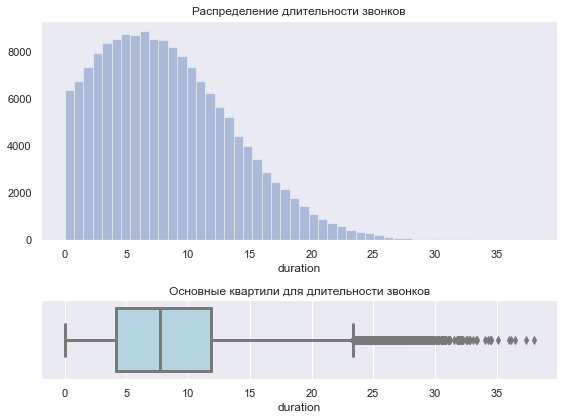

In [12]:
# посмотрим на распределение длительности звонков БЕЗ звонков нулевой длительности
figsize(8, 6)
ax1 = subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = subplot2grid((3, 1), (2, 0))

sns.distplot(calls.query('duration != 0').duration, ax=ax1, kde=False)
ax1.set_title("Распределение длительности звонков")
ax1.grid()

sns.boxplot(calls.query('duration != 0').duration, ax=ax2, linewidth=3, color='lightblue')
ax2.set_title("Основные квартили для длительности звонков")
tight_layout()

# распределение немного скошено вправо, медиана (7.74 мин) чуть меньше среднего (8.40 мин)

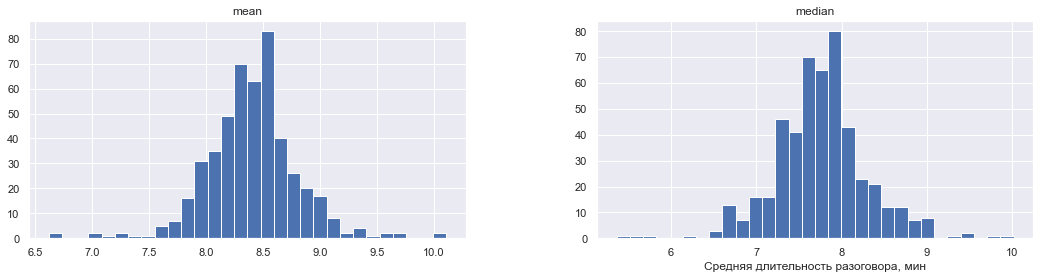

In [16]:
# проверим, что нет пользователей, у которых средняя длительность разговора сильно отличается от остальных
# и было корректно брать просто среднее по всем пользователям
calls_by_user = calls.query('duration != 0').groupby('user_id')['duration'].agg(['mean', 'median'])

calls_by_user.hist(figsize=(18,4), bins=30)
plt.xlabel('Средняя длительность разоговора, мин')
plt.show()
# видим также, что данные по звонкам есть по 492 пользователям из 500, по 8 пользователям будут пропуски в звонках в помесячной разбивке

### Предобработка данных по сообщениям

In [17]:
# переведем message_date в формат даты-времени
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
# создадим столбец с разбивкой по месяцам
messages['month'] = messages['message_date'].values.astype('datetime64[M]')
# переименуем стоблец id сообщения в message_id
messages.set_axis(['message_id', 'message_date', 'user_id', 'month'], axis='columns', inplace=True)

messages.head()

,message_id,message_date,user_id,month
0,1000_0,2018-06-27,1000,2018-06-01
1,1000_1,2018-10-08,1000,2018-10-01
2,1000_2,2018-08-04,1000,2018-08-01
3,1000_3,2018-06-16,1000,2018-06-01
4,1000_4,2018-12-05,1000,2018-12-01


In [18]:
# при слиянии в ежемесячный отчет будут пропуски для 74 человек, т.к. в этой таблице только 426 пользователей
message_by_user = messages.groupby('user_id').count()
message_by_user

,message_id,message_date,month
user_id,,,
1000,496,496,496
1002,70,70,70
1003,380,380,380
1004,1192,1192,1192
1005,552,552,552
...,...,...,...
1495,340,340,340
1496,468,468,468
1497,51,51,51


count     426.000000
mean      288.816901
std       267.607552
min         1.000000
25%        85.750000
50%       215.500000
75%       414.000000
max      1463.000000
Name: message_id, dtype: float64

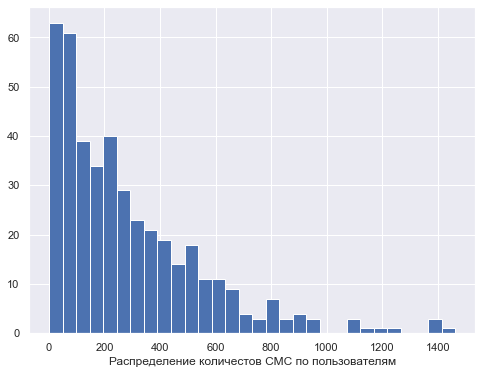

In [21]:
# есть те, кто активно пользуюется СМСками, есть кто почти не пользуется
message_by_user['message_id'].hist(bins=30)
plt.xlabel('Распределение количестов СМС по пользователям')

# распределение сильно скошено вправо, медиана (216 шт) меньше среднего (289 шт.)
message_by_user['message_id'].describe()

### Предобработка данных по интернет-трафику

In [22]:
# переведем call_date в формат даты-времени
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
# столбец-артефакт Unnamed:0, удалим его
internet = internet.drop('Unnamed: 0', axis=1)
# переименуем стоблец id интернет-сессии в internet_id
internet.set_axis(['internet_id', 'mb_used', 'session_date', 'user_id'], axis='columns', inplace=True)
# создадим столбец с разбивкой по месяцам
internet['month'] = internet['session_date'].values.astype('datetime64[M]')
# огруглим количество трафика вверх как это делает "Мегалайн"
internet['mb_used_round'] = np.ceil(internet['mb_used']).astype('int')
internet.head()

,internet_id,mb_used,session_date,user_id,month,mb_used_round
0,1000_0,112.95,2018-11-25,1000,2018-11-01,113
1,1000_1,1052.81,2018-09-07,1000,2018-09-01,1053
2,1000_2,1197.26,2018-06-25,1000,2018-06-01,1198
3,1000_3,550.27,2018-08-22,1000,2018-08-01,551
4,1000_4,302.56,2018-09-24,1000,2018-09-01,303


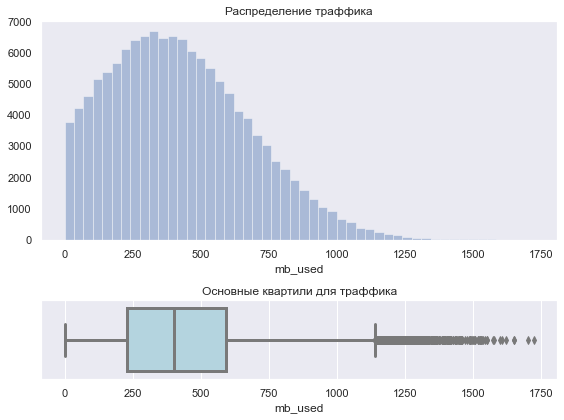

In [23]:
# в распределении траффика тоже есть сессии с нулевым трафиком (13%), смещающие среднее и медиану в меньшую сторону

# посмотрим на распределение траффика БЕЗ нулевых соединений
figsize(8, 6)
ax1 = subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = subplot2grid((3, 1), (2, 0))

sns.distplot(internet.query('mb_used != 0').mb_used, ax=ax1, kde=False)
ax1.set_title("Распределение траффика")
ax1.grid()

sns.boxplot(internet.query('mb_used != 0').mb_used, ax=ax2, linewidth=3, color='lightblue')
ax2.set_title("Основные квартили для траффика")
tight_layout()

In [24]:
# распределение немного скошено вправо, медиана (400 Мб) чуть меньше среднего (426 Мб)
internet.query('mb_used != 0')['mb_used'].describe()

count    129798.000000
mean        426.087210
std         255.596447
min           0.030000
25%         227.460000
50%         400.540000
75%         592.947500
max        1724.830000
Name: mb_used, dtype: float64

### Предобработка данных по тарифам

In [25]:
# добавим численное обозоначение для тарифов: smart -> 0, ultra -> 1
tariffs['tariff'] = pd.Series([0, 1])
# переводем плату в руб/Мб
tariffs['rub_per_mb'] = tariffs['rub_per_gb'] / 1024
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,tariff,rub_per_mb
0,50,15360,500,550,200,3,3,smart,0,0.195312
1,1000,30720,3000,1950,150,1,1,ultra,1,0.146484


###  Расчет помесячной выручки для каждого пользователя 

In [26]:
# отдельно создадим диапазон месяцев для 2018 года
month = pd.DataFrame({'month': pd.date_range('2018-01-01 00:00:00','2018-12-01 00:00:00', freq='MS')})
month

,month
0,2018-01-01
1,2018-02-01
2,2018-03-01
3,2018-04-01
4,2018-05-01
5,2018-06-01
6,2018-07-01
7,2018-08-01
8,2018-09-01
9,2018-10-01


In [27]:
# создадим ключ по которому будем объединять каждый месяц с каждым пользователям (как в SQL cross join)
users['key'] = 1
month['key'] = 1
# это будет заготовка отчета на 12 месяцев х 500 пользователей (после объединения key не нужен)
report = month.merge(users, on='key').drop('key', axis=1)

In [29]:
# возможна ситуация где человек зарегистрировался позже, чем наш созданный month - эти строки удаляем
report = report[report['month'] >= report['reg_month']]
# а также строки где пользователь уже разорвал договор 
report = report[report['month'] <= report['churn_date']]
report.head()

,month,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_month,month_sum
5,2018-01-01,1005,67,2018-12-31,Набережные Челны,Афанасий,Горлов,2018-01-25,0,2018-01-01,11
32,2018-01-01,1032,31,2018-12-31,Ульяновск,Инна,Игнатьева,2018-01-04,0,2018-01-01,11
45,2018-01-01,1045,48,2018-12-31,Улан-Удэ,Джемма,Карасева,2018-01-30,0,2018-01-01,11
55,2018-01-01,1055,39,2018-12-31,Казань,Луиза,Березина,2018-01-02,0,2018-01-01,11
71,2018-01-01,1071,20,2018-08-31,Омск,Гектор,Чумаков,2018-01-09,0,2018-01-01,7


In [30]:
# проверим по случайному из пользователей, что нет ситуации с reg_month > month и month > churn_date
report[report['user_id'] == np.random.randint(1000, 1501)]

,month,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_month,month_sum
4577,2018-10-01,1077,18,2018-12-31,Москва,Марица,Кольцова,2018-10-23,0,2018-10-01,2
5077,2018-11-01,1077,18,2018-12-31,Москва,Марица,Кольцова,2018-10-23,0,2018-10-01,2
5577,2018-12-01,1077,18,2018-12-31,Москва,Марица,Кольцова,2018-10-23,0,2018-10-01,2


In [32]:
# добавим каждому пользователю ЗВОНКИ
users_calls = users.merge(calls, on='user_id', how='left')

In [33]:
# саггрегируем звонки по каждому пользователю на каждый месяц
month_calls = users_calls.groupby(['user_id', 'month'])['duration_round'].sum().reset_index()

In [34]:
# проверим тоталы по минутам которые наговорили пользователи
print(calls['duration_round'].sum()) 
print(users_calls['duration_round'].sum())
month_calls['duration_round'].sum()

1450301
1450301.0


1450301.0

In [35]:
# набрасываем на заготовку отчета саггрегированные данные по ЗВОНКАМ
# тут ВАЖНО оставить все строки из левой таблицы, чтобы сохранились пустые ячейки для тех, кто вообще не звонил (8 человек)
report = report.merge(month_calls, how='left', on=['month', 'user_id'])

In [36]:
# добавим каждому пользователю СООБЩЕНИЯ
users_messages = users.merge(messages, on='user_id', how='left')

# саггрегируем сообщения на каждый месяц
month_messages = users_messages.groupby(['user_id', 'month'])['message_id'].count().reset_index()

In [37]:
# набрасываем на заготовку отчета саггрегированные данные по СООБЩЕНИЯМ
report = report.merge(month_messages, how='left', on=['month', 'user_id'])

In [38]:
# проверим тоталы по количеству сообщений, что ничего не потеряли
print(messages['message_id'].count()) 
month_messages['message_id'].sum()

123036


123036

In [39]:
# добавим каждому пользователю ИНТЕРНЕТ СЕССИИ
users_internet = users.merge(internet, on='user_id', how='left')
# саггрегируем сессии на каждый месяц
month_internet = users_internet.groupby(['user_id', 'month'])['mb_used_round'].sum().reset_index()

In [40]:
# набрасываем на заготовку отчета саггрегированные данные по ИНТЕРНЕТ СЕССИЯМ
report = report.merge(month_internet, how='left', on=['month', 'user_id'])

In [41]:
# где пропущенные значения пользователь не звонил или не писал или нет трафика, заменим NaN на нуль
report = report.fillna(0)

# переименуем столбцы для красоты
report.columns = ['month', 'user_id', 'age', 'churn_date', 'city', 'first_name',
       'last_name', 'reg_date', 'tariff', 'reg_month', 'month_sum',
       'calls_min', 'messages', 'internet_mb']

# переведем в целочисленный формат
report[['calls_min', 'messages', 'internet_mb']] = report[['calls_min', 'messages', 'internet_mb']].astype('int')

In [42]:
# добавим к ежемесячному отчету тариф
report = report.merge(tariffs, on='tariff')

In [43]:
# посчитаем выручку: (факт - включено) * тариф
report['calls_revenue'] = (report['calls_min'] - report['minutes_included']) * report['rub_per_minute']
report['messages_revenue'] = (report['messages'] - report['messages_included']) * report['rub_per_message']
report['internet_revenue'] = (report['internet_mb'] - report['mb_per_month_included']) * report['rub_per_mb']

# уберем артефакты с отрицательными значения выручки
for column in ['calls_revenue', 'messages_revenue', 'internet_revenue']:
    report[column] = report[column].where(report[column] > 0, 0)

In [44]:
# добавим столбец суммарной выручки по пользователю в месяц
report['month_total_revenue'] = report['calls_revenue'] + report['messages_revenue'] + \
                                report['internet_revenue'] + report['rub_monthly_fee']

### Итоговый ежемесячный отчет на каждого пользователя

In [45]:
# небходимые столбцы
report.groupby(['month', 'user_id'])[['calls_revenue', 'messages_revenue', 'internet_revenue', 'rub_monthly_fee','month_total_revenue']].sum()

calls_revenue  messages_revenue  internet_revenue  \
month      user_id                                                      
2018-01-01 1005                 0                 0          0.000000   
           1032                 0                 0       1716.210938   
           1045                 0                 0          0.000000   
           1055               153                 0        341.992188   
           1071                 0                 0         51.171875   
...                           ...               ...               ...   
2018-12-01 1494                 0                 0        446.289062   
           1495                 0                 0          0.000000   
           1496                54                 3       1054.101562   
           1497               135                 0        894.531250   
           1499                 0                48          0.000000   

                    rub_monthly_fee  month_total_revenue  
month      user_id                                        
2018-01-01 1005                 550           550.000000  
           1032                 550          2266.210938  
           1045                 550           550.000000  
           1055                 550          1044.992188  
           1071                 550           601.171875  
...                             ...                  ...  
2018-12-01 1494                 550           996.289062  
           1495                1950          1950.000000  
           1496                 550          1661.101562  
           1497                 550          1579.531250  
           1499                 550           598.000000  

[3216 rows x 5 columns]

In [46]:
smart_revenue = report.query('tariff_name == "smart"')['month_total_revenue'].sum()
ultra_revenue = report.query('tariff_name == "ultra"')['month_total_revenue'].sum()
print('Суммарная выручка от SMARTов {:.2f} руб, суммарная выручка от ULTRA {:.2f} руб'.format(smart_revenue, ultra_revenue))

Суммарная выручка от SMARTов 2749685.96 руб, суммарная выручка от ULTRA 2031572.02 руб


In [47]:
# проверим удается ли пользователям "укладываться" в бесплатные лимиты
# будем считать, что уложились, если расходы пользователя в месяц не превышают абонентскую плату
report['ratio'] = (report['month_total_revenue'] / report['rub_monthly_fee']).round(1)
in_limit_smart = len(report.query('tariff_name == "smart" and ratio <= 1')) / len(report.query('tariff_name == "smart"')) 
in_limit_ultra = len(report.query('tariff_name == "ultra" and ratio <= 1')) / len(report.query('tariff_name == "ultra"')) 
print('Для тарифа SMART в бесплатный лимит уложились {:.1%} пользователей, \n\
для тарифа ULTRA в бесплатный лимит уложились {:.1%} пользователей'.format(in_limit_smart, in_limit_ultra))

Для тарифа SMART в бесплатный лимит уложились 27.4% пользователей, 
для тарифа ULTRA в бесплатный лимит уложились 87.2% пользователей


### Выводы:
- суммарная выручка составляет 4.78 млн. руб, из них клиенты SMART 2.75 млн, клиенты ULTRA 2.03 млн. руб;
- среди пользователей тарифа SMART в оплаченный абонентской платой лимит звонков, сообщений, интернет трафика уложились 27.4% пользователей, для тарифа ULTRA - 87.2%. Этим и можно аргументировать перейти SMART пользователя на тариф ULTRA - тут включено больше минут, сообщений, мегабайт.

### Статистистики для двух групп пользователей: средние, дисперсия, стандартное отклонение

In [48]:
# среднее количество мину, сообщений, мегабайт в месяц для каждой группы
smart = report.query('tariff_name == "smart"').groupby('month')[['calls_min', 'messages', 'internet_mb']].mean().reset_index()
ultra = report.query('tariff_name == "ultra"').groupby('month')[['calls_min', 'messages', 'internet_mb']].mean().reset_index()
result = smart.join(ultra, rsuffix='_ul').drop('month_ul', axis=1).round(2)
result.columns = ['month', 'calls_smart_avg', 'messages_smart_avg', 'internet_smart_avg', 'calls_ultra_avg', 'messages_ultra_avg', 'internet_ultra_avg']
result = result[['month', 'calls_smart_avg', 'calls_ultra_avg', 'messages_smart_avg', 'messages_ultra_avg', 'internet_smart_avg', 'internet_ultra_avg']]
result

,month,calls_smart_avg,calls_ultra_avg,messages_smart_avg,messages_ultra_avg,internet_smart_avg,internet_ultra_avg
0,2018-01-01,203.85,428.11,18.24,33.78,8524.44,13153.56
1,2018-02-01,298.69,297.12,24.09,21.96,11611.40,11786.96
2,2018-03-01,390.05,489.65,31.86,32.30,15123.86,17551.97
3,2018-04-01,367.13,458.02,30.74,31.56,13479.48,16843.80
4,2018-05-01,387.36,510.33,33.77,37.85,15825.20,19381.19
5,2018-06-01,395.64,479.70,33.40,41.73,15814.77,18942.24
6,2018-07-01,408.35,545.79,33.75,49.85,15763.51,20514.65
7,2018-08-01,421.47,510.78,33.64,48.44,16632.17,19594.07
8,2018-09-01,428.61,539.44,33.64,52.29,16324.53,19222.21
9,2018-10-01,426.14,558.08,33.77,58.43,16778.56,20063.87


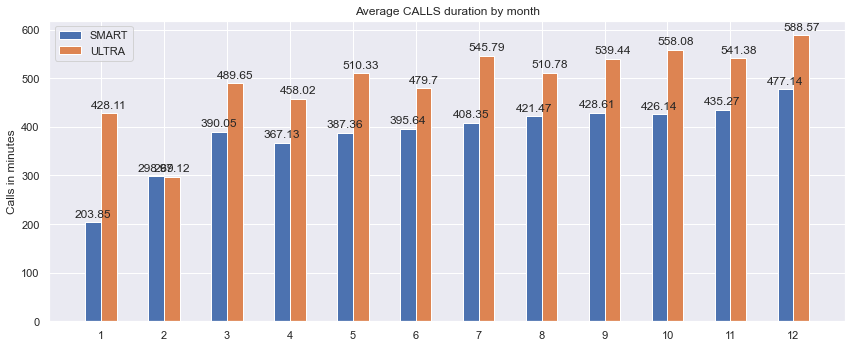

In [50]:
# тоже, но графически, ЗВОНКИ
labels = result['month'].dt.month
smart = result['calls_smart_avg']
ultra = result['calls_ultra_avg']

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar(x - width/2, smart, width, label='SMART')
rects2 = ax.bar(x + width/2, ultra, width, label='ULTRA')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Calls in minutes')
ax.set_title('Average CALLS duration by month')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
fig.tight_layout()
plt.show(figsize(12,5))

# для себя памятка https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html

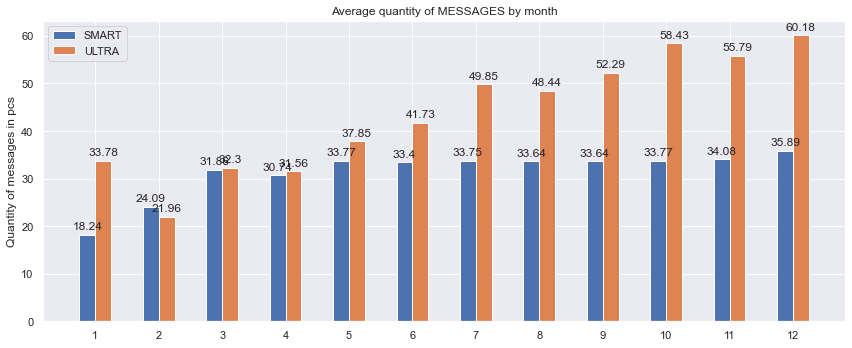

In [51]:
# тоже, но графически, СООБЩЕНИЯ
labels = result['month'].dt.month
smart = result['messages_smart_avg']
ultra = result['messages_ultra_avg']

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar(x - width/2, smart, width, label='SMART')
rects2 = ax.bar(x + width/2, ultra, width, label='ULTRA')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Quantity of messages in pcs')
ax.set_title('Average quantity of MESSAGES by month')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

autolabel(rects1)
autolabel(rects2)
fig.tight_layout()
plt.show(figsize(12,5))


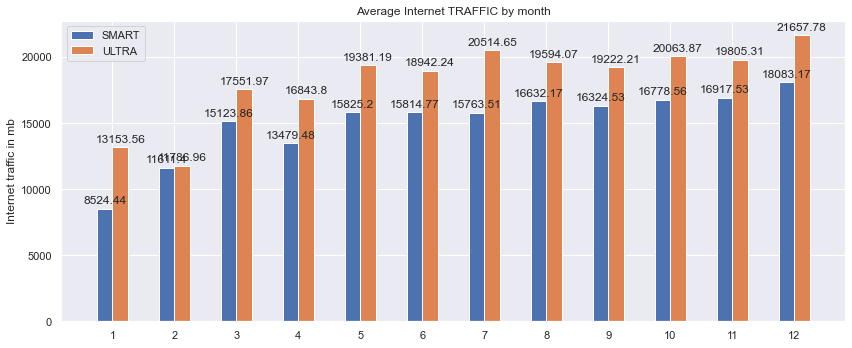

In [52]:
# тоже, но графически, интернет ТРАФИК
labels = result['month'].dt.month
smart = result['internet_smart_avg']
ultra = result['internet_ultra_avg']

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar(x - width/2, smart, width, label='SMART')
rects2 = ax.bar(x + width/2, ultra, width, label='ULTRA')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Internet traffic in mb')
ax.set_title('Average Internet TRAFFIC by month')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

autolabel(rects1)
autolabel(rects2)
fig.tight_layout()
plt.show(figsize(12,5))

In [53]:
# рассчитаем среднее, дисперсию, станд. отклонение для тарифов SMART и ULTRA для каждого парамертра:
# длительности звонков, количества сообщений, объема интернет трафика
report.groupby('tariff_name')[['calls_min', 'messages', 'internet_mb']].agg(['mean', 'var', 'std']).round(2)

calls_min                    messages                 internet_mb  \
                 mean        var     std     mean      var    std        mean   
tariff_name                                                                     
smart          417.75   36281.39  190.48    33.37   796.96  28.23    16221.91   
ultra          526.09  101052.49  317.89    49.31  2285.42  47.81    19467.14   

                                     
                      var       std  
tariff_name                          
smart        3.464852e+07   5886.30  
ultra        1.022173e+08  10110.26

### Выводы:
- пользователи тарифа Ultra в среднем за месяц наговаривают 526 мин, что на 21% больше, чем у клиентов тарифа Smart (418 мин);
-  пользователи тарифа Ultra в среднем в месяц посылают 49 сообщений, что на 33% больше, чем у клиентов тарифа Smart (33 сообщения);
- пользователи тарифа Ultra в среднем в месяц используют 19.0 Гб интернет трафика, что на 17% больше, чем у клиентов тарифа Smart (15.8 Гб).

### Гипотеза №1
- __нулевая гипотеза__: средняя ежемесячная выручка пользователей тарифа SMART равна средней ежемесячной выручки пользователей тарифа ULTRA
- __альтернативная гипотеза__: данные выручки не равны

In [54]:
# посмотрим глазками как ведет себя средняя ежемесячная выручка в зависимости от тарифа
report.groupby(['tariff_name', 'month'])['month_total_revenue'].agg(['mean', 'sum'])

mean            sum
tariff_name month                                 
smart       2018-01-01   702.556296   23886.914062
            2018-02-01   804.337689   46651.585938
            2018-03-01  1118.382508   86115.453125
            2018-04-01   922.340472  103302.132812
            2018-05-01  1146.921930  161715.992188
            2018-06-01  1149.579697  188531.070312
            2018-07-01  1168.063666  234780.796875
            2018-08-01  1258.498005  295747.031250
            2018-09-01  1199.072506  311758.851562
            2018-10-01  1304.842315  383623.640625
            2018-11-01  1283.362812  405542.648438
            2018-12-01  1503.046875  508029.843750
ultra       2018-01-01  1950.000000   17550.000000
            2018-02-01  1973.046875   47353.125000
            2018-03-01  2004.171505   74154.345703
            2018-04-01  1995.431463  109748.730469
            2018-05-01  2054.965893  137682.714844
            2018-06-01  2032.060896  170693.115234
            2018-07-01  2108.502533  191873.730469
            2018-08-01  2071.152161  221613.281250
            2018-09-01  2013.725798  231578.466797
            2018-10-01  2056.918112  253000.927734
            2018-11-01  2080.786497  278825.390625
            2018-12-01  2124.987095  297498.193359

In [55]:
# средняя месячная выручка на одного Smart и Ultra клиента
smart_revenue_avg = report.query('tariff_name == "smart"')['month_total_revenue'].mean() 
ultra_revenue_avg = report.query('tariff_name == "ultra"')['month_total_revenue'].mean() 
print('Средняя выручка от SMARTов {:.2f} руб, средняя выручка от ULTRA {:.2f} руб'.format(smart_revenue_avg, ultra_revenue_avg))

Средняя выручка от SMARTов 1233.04 руб, средняя выручка от ULTRA 2060.42 руб


In [60]:
# массивы ежемесячных выручек для разных тарифов
temp = report.groupby(['tariff_name', 'month'])['month_total_revenue'].mean().reset_index()
smart = temp.query('tariff_name == "smart"')['month_total_revenue']
ultra = temp.query('tariff_name == "ultra"')['month_total_revenue']
# сравним дисперсии для выборок ULTRA и SMART
print('Дисперсия SMART', np.var(smart, ddof=1))
print('Дисперсия ULTRA', np.var(ultra, ddof=1))

# проведем тест для предположения, что дисперсии сильно отличаются
results = st.ttest_ind(smart, ultra, equal_var=False)
print(results.pvalue)
# выберем уровень значимости как 
alpha = 0.05

print(results.pvalue < alpha)
print("Отвергаем нулевую гипотезу")

# ВЫВОД: pvalue < alpha, есть основания отклонить нулевую гипотезу и принять альтернативную
# хорошо бы провести односторонний тест, что ср. выручка ULTRA превышает ср. выручку SMART

Дисперсия SMART 49879.698944027994
Дисперсия ULTRA 2877.16310708309
8.404356952885463e-09
True
Отвергаем нулевую гипотезу


### Гипотеза №2 
- __нулевая гипотеза__: средняя ежемесячная выручка пользователей тарифа ULTRA больше средней ежемесячной выручки пользователей тарифа SMART
- __альтернативная гипотеза__: средняя ежемесячная выручка пользователей тарифа ULTRA не превышает среднюю ежемесячную выручку пользователей тарифа SMART

In [61]:
results = st.ttest_1samp(ultra, smart_revenue_avg)
# тест односторонний: p-value будет в два раза меньше
print('p-значение: ', results.pvalue / 2)

# отвергаем гипотезу только если выборочное среднее значимо больше предполагаемого значения
if (results.pvalue / 2 < alpha) and (ultra.mean() > smart_revenue_avg):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")


p-значение:  8.120215655034958e-15
Отвергаем нулевую гипотезу


### Гипотеза №3
- __нулевая гипотеза__: средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов
- __альтернативная гипотеза__: данные средние выручки не равны

In [58]:
moscow_revenue = report.query('city == "Москва"')['month_total_revenue'].mean()
other_revenue = report.query('city != "Москва"')['month_total_revenue'].mean()
print('Средняя выручка по Москве {:.2f} руб, средняя выручка от прочих регионов {:.2f} руб'.format(moscow_revenue, other_revenue))

Средняя выручка по Москве 1507.28 руб, средняя выручка от прочих регионов 1481.89 руб


In [63]:
# для Москвы и остальных городов
moscow = report.query('city == "Москва"').groupby('month')['month_total_revenue'].mean()
other = report.query('city != "Москва"').groupby('month')['month_total_revenue'].mean()

print('Дисперсия Москвы', np.var(moscow, ddof=1))
print('Дисперсия Замкадья :)', np.var(other, ddof=1))

# проведем тест для условия, что дисперсии сильно отличаются
results = st.ttest_ind(moscow, other, equal_var=False)
print('p-значение: ', results.pvalue)
print(results.pvalue < alpha)
print('p-pvalue > 0.05, нет оснований отклонить нулевую гипотезу')


Дисперсия Москвы 14056.635726307186
Дисперсия Замкадья :) 49054.58466116653
p-значение:  0.23982562382508793
False
p-pvalue > 0.05, нет оснований отклонить нулевую гипотезу


### Выводы:
- средние ежемесячные выручки пользовалей тарифов SMART и ULTRA значимо отличаются;
- средняя ежемесячная выручка пользователей тарифа ULTRA значимо превышает  среднюю ежемесячную выручку пользователей тарифа SMART;
- нет значимых отличий между средней ежемесячной выручкой пользователей из Москвы и пользователями из других регионов.

### Общий вывод:
- за 2018 год бОльшую суммарную выручку компании принес тариф SMART 2.75 млн.руб против 2.03 млн.руб для тарифа ULTRA. Такой результат является следствием того, что количество пользователей тарифа SMART (351 человек) более чем в 2 раза превышает количество пользователей тарифа ULTRA (149 человек);
- при этом пользователи ULTRA активнее, у них на 17-30% больше звонков, сообщений, интернет-трафика;
- в среднем за месяц выручка от пользователей тарифа ULTRA (2060 руб) больше, чем от пользователей тарифа SMART - 1233 руб. Можно порекомендовать компании сконцентрировать усилия на привлечение новых пользователей именно на тариф ULTRA (или создать благоприятные условия для перехода на него, имеющихся пользователей с тарифа SMART).